## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

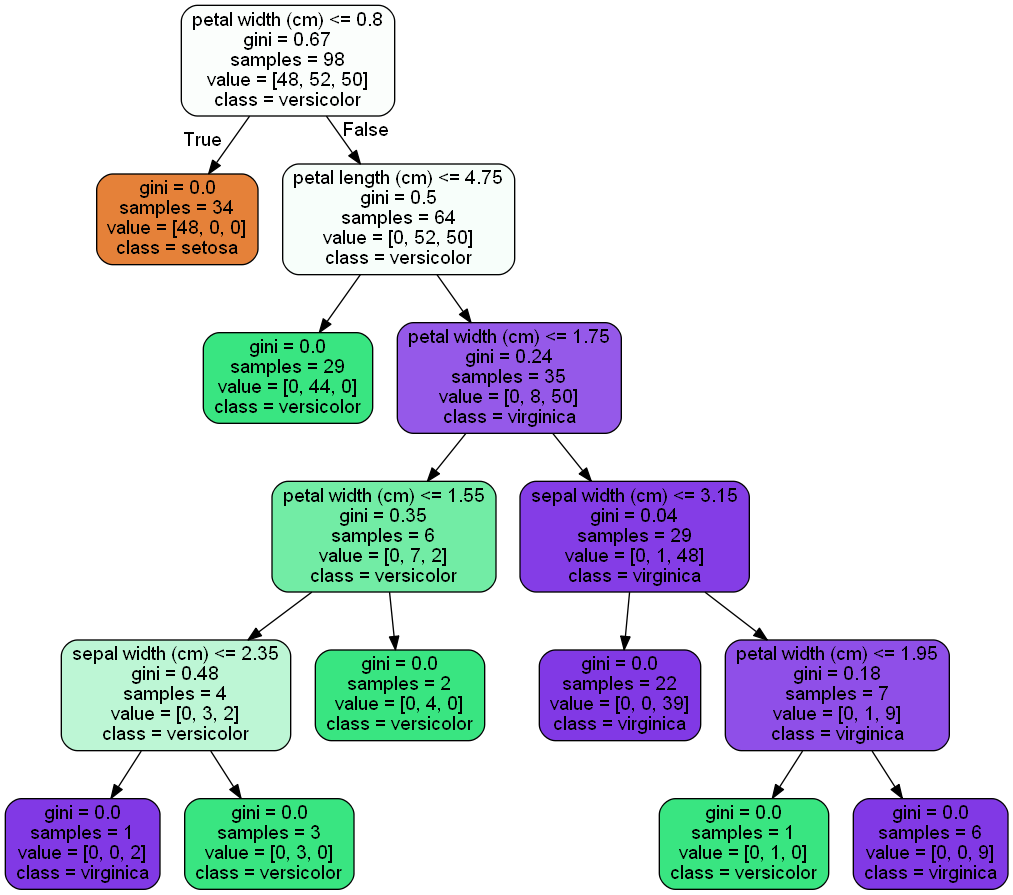

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
#from subprocess import call
#call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
import pydot

(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [3]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [4]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [5]:
df.shape

(2218, 18)

In [6]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [7]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [8]:
df['n_age'] = datetime.now().year - df['birth_year']
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,57.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,34.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,57.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,30.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,29.0


### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [9]:
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,n_age,454


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [11]:
df['disease'].fillna(0, inplace=True)

In [12]:
df['disease'].replace(True, 1, inplace=True)

In [13]:
df['disease'].value_counts()

0    2199
1      19
Name: disease, dtype: int64

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [14]:
cols = ['global_num', 'birth_year', 'infection_order', 'infected_by', 'contact_number']

for col in cols:
    df[col].fillna(np.mean(df[col]), inplace=True)

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [15]:
# We can fill the n_age NaN values again since we have filxed the NaN birth_year rows
df['n_age'].fillna(datetime.now().year - df['birth_year'], inplace=True)

In [16]:
# We can also fill the age column using the n_age
df['age'].fillna(str(df['n_age'])[0] + '0s',inplace=True)

In [17]:
# We also drop date columns from the data
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

The remaining columns with NaNs are all categorical. We need a strategy to fill these.

In [18]:
df.isnull().sum().sort_values(ascending=False)

infection_case     1055
sex                 145
state                88
city                 65
patient_id            0
global_num            0
birth_year            0
age                   0
country               0
province              0
disease               0
infection_order       0
infected_by           0
contact_number        0
n_age                 0
dtype: int64

What are the options in dealing with null categorical variables?
We can:
1. Ignore observation
2. Replace by most frequent value
3. Replace using an algorithm like KNN using the neighbours
4. Predict the observation using a multiclass predictor

Option 1 isn't favorable since we would like to see how these features affect our model.

Option 2 isn't ideal either since one feature accounts for a large portion of the data, so replacing the null with the most frequent value would heavily skew the data.

We can try option 3 and use KNN to take care of the remaining null values.


The KNN algorithm is based on Euclidean distances. So, if the categories are binary, then using 1 and 0 is okay, but as soon as we get more categories then things can get problematic. 
One possibility is to put them equally spaced around a circle, since then the distance between any pair of them is the same. With over 3 values, we can also put them at the vertices of a regular simplex in N-dimensional space. Then in this case the distance between any two of them would be the same as well. 

In [19]:
from fancyimpute import KNN
from sklearn.preprocessing import OrdinalEncoder

In [20]:
#instantiate both packages to use
encoder = OrdinalEncoder()
imputer = KNN()

categories = ['infection_case', 'sex','state', 'city','age','country','province']

def encode(data):
    '''
    function to encode non-null data and 
    replace it in the original data
    '''
    
    #retains only non-null values
    nonulls = np.array(data.dropna())
    
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data


In [21]:
for cat in categories:
    encode(df[cat])

C:\Users\18324\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\18324\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\18324\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [22]:
# impute data and convert 
imputed_df = pd.DataFrame(np.round(imputer.fit_transform(df)),columns = df.columns)

Imputing row 1/2218 with 0 missing, elapsed time: 0.621
Imputing row 101/2218 with 0 missing, elapsed time: 0.622
Imputing row 201/2218 with 0 missing, elapsed time: 0.622
Imputing row 301/2218 with 0 missing, elapsed time: 0.623
Imputing row 401/2218 with 1 missing, elapsed time: 0.623
Imputing row 501/2218 with 0 missing, elapsed time: 0.626
Imputing row 601/2218 with 0 missing, elapsed time: 0.626
Imputing row 701/2218 with 0 missing, elapsed time: 0.626
Imputing row 801/2218 with 0 missing, elapsed time: 0.626
Imputing row 901/2218 with 0 missing, elapsed time: 0.629
Imputing row 1001/2218 with 0 missing, elapsed time: 0.629
Imputing row 1101/2218 with 1 missing, elapsed time: 0.630
Imputing row 1201/2218 with 1 missing, elapsed time: 0.632
Imputing row 1301/2218 with 1 missing, elapsed time: 0.635
Imputing row 1401/2218 with 1 missing, elapsed time: 0.637
Imputing row 1501/2218 with 1 missing, elapsed time: 0.639
Imputing row 1601/2218 with 1 missing, elapsed time: 0.641
Imputing 

 **<font color='teal'> Check for any remaining null values.</font>**

In [23]:
imputed_df.isnull().sum().sort_values(ascending=False)

patient_id         0
global_num         0
sex                0
birth_year         0
age                0
country            0
province           0
city               0
disease            0
infection_case     0
infection_order    0
infected_by        0
contact_number     0
state              0
n_age              0
dtype: int64

In [24]:
imputed_df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age
0,1.000000e+09,2.0,1.0,1964.0,7.0,1.0,15.0,34.0,0.0,15.0,1.0,2.600789e+09,75.0,2.0,57.0
1,1.000000e+09,5.0,1.0,1987.0,5.0,1.0,15.0,76.0,0.0,15.0,1.0,2.600789e+09,31.0,2.0,34.0
2,1.000000e+09,6.0,1.0,1964.0,7.0,1.0,15.0,74.0,0.0,11.0,2.0,2.002000e+09,17.0,2.0,57.0
3,1.000000e+09,7.0,1.0,1991.0,4.0,1.0,15.0,77.0,0.0,15.0,1.0,2.600789e+09,9.0,2.0,30.0
4,1.000000e+09,9.0,0.0,1992.0,4.0,1.0,15.0,99.0,0.0,11.0,2.0,1.000000e+09,2.0,2.0,29.0


Review the count of unique values by column.

In [25]:
print(imputed_df.nunique())

patient_id         2218
global_num         1304
sex                   2
birth_year           96
age                  12
country               4
province             17
city                134
disease               2
infection_case       16
infection_order       6
infected_by         207
contact_number       72
state                 3
n_age                96
dtype: int64


Review the percent of unique values by column.

In [26]:
print(imputed_df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.587917
sex                0.000902
birth_year         0.043282
age                0.005410
country            0.001803
province           0.007665
city               0.060415
disease            0.000902
infection_case     0.007214
infection_order    0.002705
infected_by        0.093327
contact_number     0.032462
state              0.001353
n_age              0.043282
dtype: float64


Review the range of values per column.

In [27]:
imputed_df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4.014678e+09,2.192419e+09,1.000000e+09,1.700000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2218.0,4.664891e+03,2.211785e+03,1.000000e+00,4.205250e+03,4.665000e+03,5.900250e+03,8.717000e+03
sex,2218.0,4.233544e-01,4.942019e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
birth_year,2218.0,1.974991e+03,1.731123e+01,1.916000e+03,1.965000e+03,1.975000e+03,1.988000e+03,2.020000e+03
age,2218.0,5.320559e+00,2.688209e+00,0.000000e+00,4.000000e+00,6.000000e+00,7.000000e+00,1.100000e+01
country,2218.0,9.968440e-01,8.219450e-02,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00
province,2218.0,8.059062e+00,3.817633e+00,0.000000e+00,7.000000e+00,8.000000e+00,8.000000e+00,1.600000e+01
city,2218.0,6.068711e+01,3.642638e+01,0.000000e+00,3.100000e+01,6.000000e+01,8.900000e+01,1.330000e+02
disease,2218.0,8.566276e-03,9.217769e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_case,2218.0,9.525699e+00,3.103756e+00,0.000000e+00,9.000000e+00,1.000000e+01,1.100000e+01,1.500000e+01


### Check for duplicated rows

In [28]:
duplicateRowsDF = imputed_df[imputed_df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


### Split the data into test and train subsamples

In [57]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y
features = ['global_num', 'sex', 'age', 'country', 'province', 'city',
       'disease', 'infection_case', 'infection_order', 'infected_by',
       'contact_number', 'n_age']

X = imputed_df[features]
y = imputed_df.state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [58]:
imputed_df.state.value_counts()

1.0    1878
2.0     308
0.0      32
Name: state, dtype: int64

### Scale data to prep for model creation

In [49]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [35]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [52]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.867
Random Forest: f1-score=0.841


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [59]:
class_names=['isolated','released','deceased'] # name  of classes

Confusion matrix, without normalization
[[  7   0   0]
 [  0 359   8]
 [  0  51  19]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.98 0.02]
 [0.   0.73 0.27]]


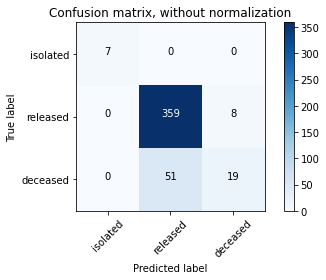

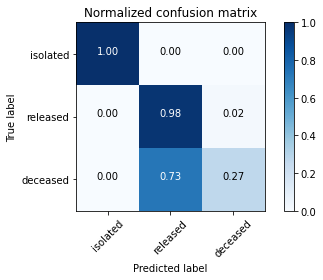

In [60]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

12


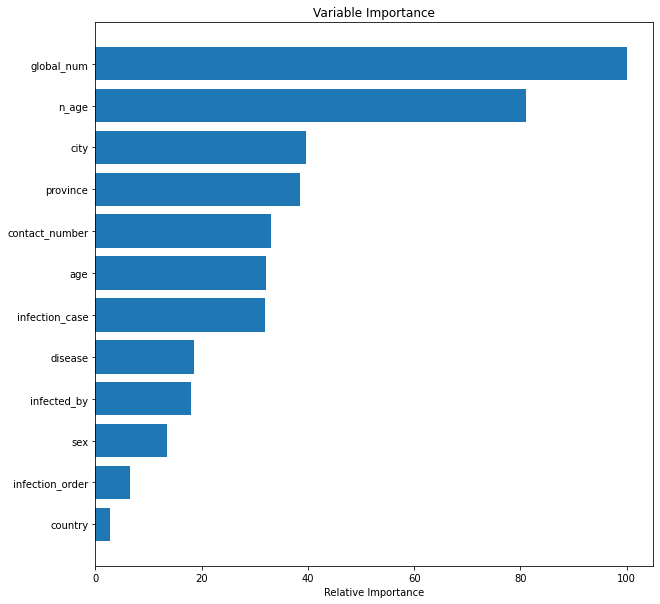

In [61]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.